In [1]:
import jax

jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")

from typing import Callable

import equinox as eqx
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax
from jaxtyping import Array, PRNGKeyArray, Scalar

import optimal_control.constraints as constraints
import optimal_control.controls as controls
import optimal_control.solvers as solvers
import optimal_control.trainers as trainers
from optimal_control.environments.examples.fibrosis2 import (
    FibrosisEnvironment,
    FibrosisState,
    _fibrosis_ode,
)

# Train controls with constant integrals

In [2]:
# Optimize trajectories

key = jax.random.PRNGKey(1234)

key, subkey = jax.random.split(key, num=2)
control = controls.ImplicitControl(
    controls.Siren(
        in_features=1, out_features=2, hidden_features=64, hidden_layers=2, key=subkey
    ),
    t_start=0.0,
    t_end=200.0,
)

solver = solvers.DirectSolver(
    optimizer=optax.adamw(learning_rate=1e-4, weight_decay=1e-2),
    num_control_points=1024,
)

environment: FibrosisEnvironment = FibrosisEnvironment()
state = environment.init()


def reward_fn(y1: Array) -> Scalar:
    return y1[4]


@eqx.filter_jit
def train_with_integral(
    control: controls.AbstractControl, integral: Array, key: PRNGKeyArray
) -> controls.AbstractControl:
    return trainers.solve_optimal_control_problem(
        num_train_steps=256,
        environment=environment,
        reward_fn=reward_fn,
        constraint_chain=[constraints.NonNegativeConstantIntegralConstraint(integral)],
        solver=solver,
        control=control,
        key=key,
        pbar_interval=8,
    )


key, train_key = jax.random.split(key, num=2)

In [21]:
from tqdm.auto import tqdm as tq


c_pdgf1_ab_series = jnp.geomspace(1e-2, 1e0, num=4)
c_csf1_ab_series = jnp.geomspace(1e-2, 1e0, num=4)

c_ab_series = jnp.stack(
    jnp.meshgrid(c_pdgf1_ab_series, c_csf1_ab_series), axis=-1
).reshape(-1, 2)


optimized_controls = []
for c_ab in tq(c_ab_series):
    optimized_controls.append(train_with_integral(control, c_ab, train_key))

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

In [22]:
import pickle

with open("/home/lena/master-thesis/repos/optimal-control/results/fibrosis2/optimization_results.pickle", mode="wb") as f:
    pickle.dump(optimized_controls, f)

# Plots

In [42]:
from optimal_control.solvers.base import build_control
import diffrax


@eqx.filter_jit
def get_trajectory(
    control: controls.AbstractControl, integral: Array
) -> diffrax.Solution:
    control = build_control(
        control, [constraints.NonNegativeConstantIntegralConstraint(integral)], 1024
    )

    return environment._integrate(
        t0=0.0,
        t1=200.0,
        y0=state.y0,
        control=control,
        inflammation_pulse=False,
        saveat=diffrax.SaveAt(dense=True),
        max_steps=10000,
        throw=True,
    )

@eqx.filter_jit
def get_constant_trajectory(
    integral: Array
) -> diffrax.Solution:
    control = controls.LambdaControl(lambda t: integral)

    return environment._integrate(
        t0=0.0,
        t1=200.0,
        y0=state.y0,
        control=control,
        inflammation_pulse=False,
        saveat=diffrax.SaveAt(dense=True),
        max_steps=10000,
        throw=True,
    )

In [24]:
optimized_trajectories = []
for i, c_ab in enumerate(c_ab_series):
    trajectory = get_trajectory(optimized_controls[i][1], c_ab)
    optimized_trajectories.append(trajectory)

In [43]:
constant_trajectories = []
for i, c_ab in enumerate(c_ab_series):
    trajectory = get_constant_trajectory(c_ab)
    constant_trajectories.append(trajectory)

In [25]:
# Load the seperatrix

import scipy.io

seperatrix_array = scipy.io.loadmat("../data/Separatrix_array_F06_M07.mat")

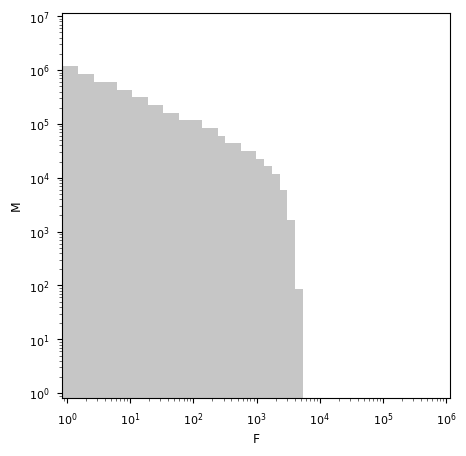

In [26]:
with plt.style.context("seaborn-paper"):
    x = np.logspace(
        seperatrix_array["lims_F"][0, 0],
        seperatrix_array["lims_F"][0, 1],
        seperatrix_array["tsteps"][0, 0],
    )
    y = np.logspace(
        seperatrix_array["lims_M"][0, 0],
        seperatrix_array["lims_M"][0, 1],
        seperatrix_array["tsteps"][0, 0],
    )

    plt.figure(figsize=(5, 5))
    plt.xlabel("F")
    plt.ylabel("M")
    plt.xscale("log")
    plt.yscale("log")
    plt.pcolor(x, y, 1 - seperatrix_array["S"], cmap="Greys", vmin=0.0, vmax=3.0)
    plt.show()

/home/lena/python39-optimal-control-env/lib/python3.9/site-packages/matplotlib/patches.py:3328: RuntimeWarning: invalid value encountered in scalar divide
  cos_t, sin_t = head_length / head_dist, head_width / head_dist


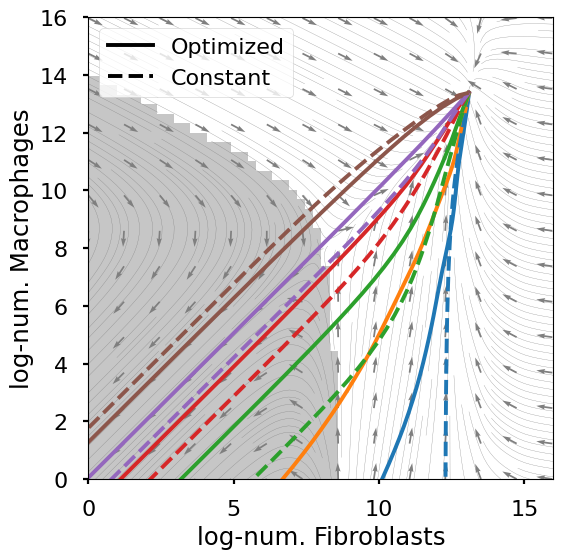

In [68]:
# Prepare gradient field
import matplotlib


def get_cp_steady_state(F, M):
    lambda1 = 0.9
    lambda2 = 0.8
    mu1 = 0.3
    mu2 = 0.3
    K = 1e6
    gamma = 2
    beta3 = 240 * 1440
    beta1 = 470 * 1440
    beta2 = 70 * 1440
    alpha1 = 940 * 1440
    alpha2 = 510 * 1440
    k1 = 6 * 1e8
    k2 = 6 * 1e8

    C = -0.5 * (alpha1 / gamma * M + k2 - beta1 / gamma * F) + jnp.sqrt(
        0.25 * (alpha1 / gamma * M + k2 - beta1 / gamma * F) ** 2
        + beta1 * k2 / gamma * F
    )
    P = 0.5 * (beta2 / gamma * M + (beta3 - alpha2) / gamma * F - k1) + jnp.sqrt(
        0.25 * (k1 - beta2 / gamma * M - (beta3 - alpha2) / gamma * F) ** 2
        + (beta2 * M + beta3 * F) * k1 / gamma
    )

    return C, P


"""
f = jnp.geomspace(1e0, 1e9)
m = jnp.geomspace(1e0, 1e9)

f, m = jnp.meshgrid(f, m)
c, p = get_cp_steady_state(f, m)
y = jnp.stack((f, m, c, p))
dfdt, dmdt = jnp.split(_fibrosis_ode(jnp.float_(0.0), y, jnp.zeros(2), jnp.float_(0.0)), 2, axis=-1)
"""

ln_f_s = jnp.linspace(
    jnp.log(10 ** seperatrix_array["lims_F"][0, 0]),
    jnp.log(10 ** seperatrix_array["lims_F"][0, 1]),
    seperatrix_array["tsteps"][0, 0],
)
ln_m_s = jnp.linspace(
    jnp.log(10 ** seperatrix_array["lims_M"][0, 0]),
    jnp.log(10 ** seperatrix_array["lims_M"][0, 1]),
    seperatrix_array["tsteps"][0, 0],
)

ln_f = jnp.linspace(
    jnp.log(10**0),
    jnp.log(10**8),
    16,
)
ln_m = jnp.linspace(
    jnp.log(10**0),
    jnp.log(10**8),
    16,
)

f = jnp.exp(ln_f)
m = jnp.exp(ln_m)

f, m = jnp.meshgrid(f, m)
c, p = get_cp_steady_state(f, m)
y = jnp.stack((f, m, c, p))

d_dt = _fibrosis_ode(jnp.float_(0.0), y, jnp.zeros(2), jnp.float_(0.0))
dfdt = d_dt[..., 0]
dmdt = d_dt[..., 1]

d_lnf_dt = dfdt / f
d_lnm_dt = dmdt / m

with plt.style.context("seaborn-poster"):
    plt.figure(figsize=(6, 6))
    # """
    plt.streamplot(
        np.asarray(ln_f),
        np.asarray(ln_m),
        np.asarray(d_lnf_dt),
        np.asarray(d_lnm_dt),
        maxlength=4.0,
        density=2.5,
        linewidth=0.2,
        arrowsize=0.0,
        color="tab:gray",
    )
    # """
    plt.pcolor(
        ln_f_s, ln_m_s, 1 - seperatrix_array["S"], cmap="Greys", vmin=0.0, vmax=3.0
    )
    # """
    plt.quiver(
        np.asarray(ln_f),
        np.asarray(ln_m),
        np.asarray(d_lnf_dt / jnp.sqrt(d_lnf_dt**2 + d_lnm_dt**2)),
        np.asarray(d_lnm_dt / jnp.sqrt(d_lnf_dt**2 + d_lnm_dt**2)),
        angles="xy",
        color="tab:gray",
    )
    # """

    colorcycle = matplotlib.rcParams["axes.prop_cycle"].by_key()["color"]

    which = [12, 8, 13, 9, 14, 7]
    #which = list(range(6, 16))

    for i, idx in enumerate(which):
        solution = optimized_trajectories[idx]
        ts = jnp.linspace(0.0, 200.0, num=128)
        trajectory = jax.vmap(solution.interpolation.evaluate)(ts)

        plt.plot(*jnp.log(trajectory[..., :2].T), c=colorcycle[i])#, label=str(idx))

    for i, idx in enumerate(which):
        solution = constant_trajectories[idx]
        ts = jnp.linspace(0.0, 200.0, num=128)
        trajectory = jax.vmap(solution.interpolation.evaluate)(ts)

        plt.plot(*jnp.log(trajectory[..., :2].T), c=colorcycle[i], linestyle="--")

    plt.xlabel("log-num. Fibroblasts")
    plt.ylabel("log-num. Macrophages")
    plt.xlim([0, 16])
    plt.ylim([0, 16])

    plt.plot([], [], c="black", label="Optimized")
    plt.plot([], [], c="black", linestyle="--", label="Constant")

    plt.legend(loc="upper left")
    
    plt.savefig(
        "/home/lena/master-thesis/repos/optimal-control/results/fibrosis2/traj.png",
        bbox_inches="tight",
    )
    plt.savefig(
        "/home/lena/master-thesis/repos/optimal-control/results/fibrosis2/traj.svg",
        bbox_inches="tight",
    )

    plt.show()

# 12, 8, 13, 9, 14, 6, 7